## Environment Setting

In [1]:
# !pip install -U torch==1.10.2 torchvision==0.11.3 -f https://download.pytorch.org/whl/cu118/torch_stable.html
!pip install cython pyyaml==5.4.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install dominate==2.4.0
# !pip install detectron2==0.1.2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html
# !pip install detectron2==0.1.2 -f https://dl.fbaipublicfiles.com/detectron2/whheecu118/index.html
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 25.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.4/662.4 kB 9.4 MB/s eta 0:00:0000:01
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-g0_4kgeh
  Running command git clone --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-g0_4kgeh
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp38-cp38-linux_x86_64.whl size=417849 sha256=cf6771a810387fbbc659fa6dc1dafb1948864a116fe18d219cde2092445e40d1
  Stored in directory: /tmp/pip-ephem-wheel-cache-2o0_6m9t/wheels/56/da/49/cb71a7c450b59588934077f431100c05fbde50646ee84a8d40
Successfully built pycocotools
  Cloning https:

In [ ]:
!nvcc --version


## Clone the file from Gihub

In [ ]:
!git clone https://github.com/ericsujw/InstColorization.git

## Start Colorization

In [3]:
import os

In [5]:
os.chdir('InstColorization')
print(os.getcwd())

/home/chandanGP/AIP_proj/InstColorization


## Download the Model

### Detect Object bounding box


Setting the Detectron2.

In [7]:
from os.path import join, isfile, isdir
from os import listdir
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from argparse import ArgumentParser

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import cv2

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

import torch

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

[08/01 22:03:08 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x/139653917/model_final_2d9806.pkl ...


model_final_2d9806.pkl: 431MB [02:47, 2.58MB/s]                               


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
! unzip checkpoints.zip -d checkpoints

Archive:  checkpoints.zip
   creating: checkpoints/checkpoints/
   creating: checkpoints/checkpoints/coco_finetuned_mask_256_ffs/
  inflating: checkpoints/checkpoints/coco_finetuned_mask_256_ffs/latest_net_GComp.pth  
  inflating: checkpoints/checkpoints/coco_finetuned_mask_256_ffs/latest_net_G.pth  
  inflating: checkpoints/checkpoints/coco_finetuned_mask_256_ffs/latest_net_GF.pth  
   creating: checkpoints/checkpoints/coco_finetuned_mask_256/
  inflating: checkpoints/checkpoints/coco_finetuned_mask_256/latest_net_GComp.pth  
  inflating: checkpoints/checkpoints/coco_finetuned_mask_256/latest_net_G.pth  
  inflating: checkpoints/checkpoints/coco_finetuned_mask_256/latest_net_GF.pth  
   creating: checkpoints/checkpoints/siggraph_retrained/
  inflating: checkpoints/checkpoints/siggraph_retrained/latest_net_G.pth  


Let's create a bounding box folder to save our prediction results.

In [18]:

input_dir = "/home/chandanGP/AIP_proj/InstColorization/example"
# input_dir = "/content/drive/MyDrive/AIP_project/diff_lumin"
image_list = [f for f in listdir(input_dir) if isfile(join(input_dir, f))]
output_npz_dir = "{0}_bbox".format(input_dir)
if os.path.isdir(output_npz_dir) is False:
    print('Create path: {0}'.format(output_npz_dir))
    os.makedirs(output_npz_dir)

Create path: /home/chandanGP/AIP_proj/InstColorization/example_bbox


In [19]:
image_list

['8b01a894fb91025a1dc77611838e9d13.jpg',
 '574100c6e31a1dcd096476eb2d632b3c.jpg',
 'e9b6826aa623549ec77bbc0275002779.jpg',
 '000000046872.jpg',
 '000000022969.jpg',
 '000000023781.jpg',
 '925f179ba736e15e89bfd6d88e0bba56.jpg',
 '000000050145.jpg']

Here we simply take L channel as our input and make sure that we can get consistent box prediction results even though the original image is color images.

In [20]:
for image_path in image_list:
    img = cv2.imread(join(input_dir, image_path))
    lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel, a_channel, b_channel = cv2.split(lab_image)
    l_stack = np.stack([l_channel, l_channel, l_channel], axis=2)
    outputs = predictor(l_stack)
    save_path = join(output_npz_dir, image_path.split('.')[0])
    pred_bbox = outputs["instances"].pred_boxes.to(torch.device('cpu')).tensor.numpy()
    pred_scores = outputs["instances"].scores.cpu().data.numpy()
    np.savez(save_path, bbox = pred_bbox, scores = pred_scores)

/home/chandanGP/anaconda3/envs/gp/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343962757/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Now we have all the images' prediction results.

In [21]:
!ls example_bbox

000000022969.npz  574100c6e31a1dcd096476eb2d632b3c.npz
000000023781.npz  8b01a894fb91025a1dc77611838e9d13.npz
000000046872.npz  925f179ba736e15e89bfd6d88e0bba56.npz
000000050145.npz  e9b6826aa623549ec77bbc0275002779.npz


### Colorize Images

We first set up some libraries and options

In [22]:
import sys
import time
from options.train_options import TestOptions
from models import create_model

import torch
from tqdm import tqdm_notebook

from fusion_dataset import Fusion_Testing_Dataset
from util import util
import multiprocessing
multiprocessing.set_start_method('spawn', True)

torch.backends.cudnn.benchmark = True

sys.argv = [sys.argv[0]]
opt = TestOptions().parse()

Then we need to create a results folder to save our predicted color images and read the dataset loader.

In [23]:
save_img_path = opt.results_img_dir
if os.path.isdir(save_img_path) is False:
    print('Create path: {0}'.format(save_img_path))
    os.makedirs(save_img_path)
opt.batch_size = 1
dataset = Fusion_Testing_Dataset(opt, -1)
dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=opt.batch_size)

dataset_size = len(dataset)
print('#Testing images = %d' % dataset_size)

Create path: results
#Testing images = 8


Load the pre-trained model.

In [25]:
model = create_model(opt)
model.setup_to_test('coco_finetuned_mask_256_ffs')

initialize network with normal
initialize network with normal
initialize network with normal
model [FusionModel] was created
load Fusion model from checkpoints/coco_finetuned_mask_256_ffs/latest_net_GF.pth


Start to colorize every images in `dataset_loader`.

In [ ]:
count_empty = 0
for data_raw in tqdm_notebook(dataset_loader):
    data_raw['full_img'][0] = data_raw['full_img'][0].cuda()
    if data_raw['empty_box'][0] == 0:
        data_raw['cropped_img'][0] = data_raw['cropped_img'][0].cuda()
        box_info = data_raw['box_info'][0]
        box_info_2x = data_raw['box_info_2x'][0]
        box_info_4x = data_raw['box_info_4x'][0]
        box_info_8x = data_raw['box_info_8x'][0]
        cropped_data = util.get_colorization_data(data_raw['cropped_img'], opt, ab_thresh=0, p=opt.sample_p)
        full_img_data = util.get_colorization_data(data_raw['full_img'], opt, ab_thresh=0, p=opt.sample_p)
        model.set_input(cropped_data)
        model.set_fusion_input(full_img_data, [box_info, box_info_2x, box_info_4x, box_info_8x])
        model.forward()
    else:
        count_empty += 1
        full_img_data = util.get_colorization_data(data_raw['full_img'], opt, ab_thresh=0, p=opt.sample_p)
        model.set_forward_without_box(full_img_data)
    model.save_current_imgs(join(save_img_path, data_raw['file_id'][0] + '.png'))
print('{0} images without bounding boxes'.format(count_empty))

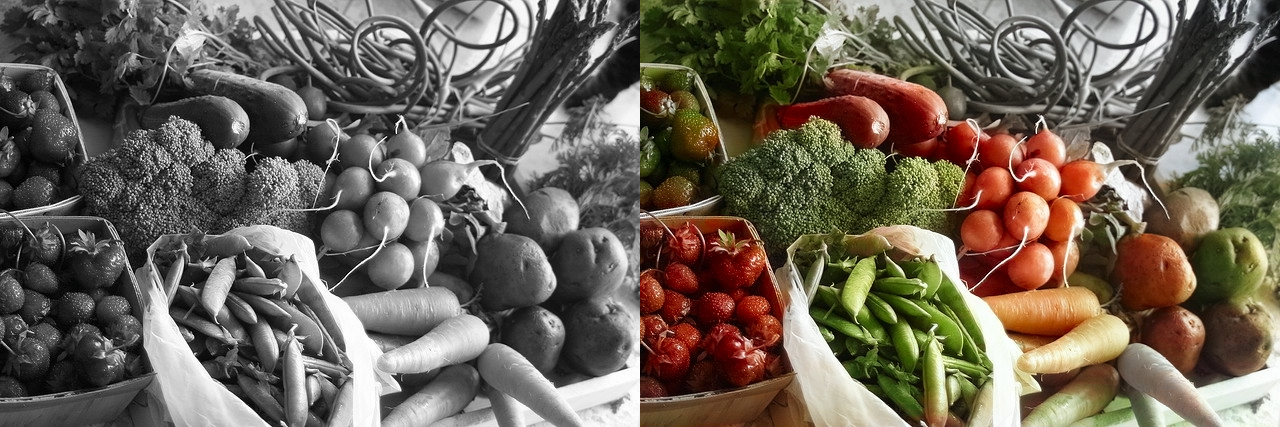

In [ ]:
from google.colab.patches import cv2_imshow
img_name_list = ['000000022969', '000000023781', '000000046872', '000000050145']
show_index = 1

img = cv2.imread('example/'+img_name_list[show_index]+'.jpg')
lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
l_channel, _, _ = cv2.split(lab_image)

img = cv2.imread('results/'+img_name_list[show_index]+'.png')
lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
_, a_pred, b_pred = cv2.split(lab_image)
a_pred = cv2.resize(a_pred, (l_channel.shape[1], l_channel.shape[0]))
b_pred = cv2.resize(b_pred, (l_channel.shape[1], l_channel.shape[0]))
gray_color = np.ones_like(a_pred) * 128

gray_image = cv2.cvtColor(np.stack([l_channel, gray_color, gray_color], 2), cv2.COLOR_LAB2BGR)
color_image = cv2.cvtColor(np.stack([l_channel, a_pred, b_pred], 2), cv2.COLOR_LAB2BGR)

# save_img_path = 'results_origin/'
# if os.path.isdir(save_img_path) is False:
#     print('Create path: {0}'.format(save_img_path))
#     os.makedirs(save_img_path)

# cv2.imwrite('results_origin/'+img_name_list[show_index]+'.png', color_image)

cv2_imshow(np.concatenate([gray_image, color_image], 1))